In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import sys
import imageio
%matplotlib inline 
import matplotlib.pyplot as plt
# from scipy.ndimage import imread
from scipy import misc
from os import listdir
from tensorflow.python.platform import gfile
from scipy.spatial.distance import cdist
from datetime import datetime
import os

Instructions for updating:
non-resource variables are not supported in the long term


In [7]:
def create_graph(graphDir=None):
    """"Creates a graph from saved GraphDef file and returns a saver."""
    # Creates graph from saved graph_def.pb.
    # if graph directory is not given, it is the default
    if graphDir == None:
        graphDir = r"C:\Users\gprak\Downloads\Research Papers\classify_image_graph_def.pb"
    with tf.Session() as sess:
        with gfile.FastGFile(graphDir, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            _ = tf.import_graph_def(graph_def, name='')
    return sess.graph

In [22]:
def get_feat_reps(X,class_t):
    """
    Returns the feature representation of some images by looking at the penultimate layer of inception-v3
    Parameters
    ----------
    X : ndarray
        input images all put in a numpy array
    class_t : string
        class of the images which we are doing feature extractions for.
        Note that this is only used for printing summary of progress. So just give it some
        random name if you don't care
    Returns
    -------
    res: ndarray
        feature represntation of the input images X. should have same length of X
    """
    #parameters
    feat_tensor_name = 'pool_3:0'
    input_tensor_name = 'DecodeJpeg:0'

    #get a session and create the graph
    sess = tf.Session()
    create_graph()

    #get needed tensors
    feat_tensor = sess.graph.get_tensor_by_name(feat_tensor_name)
    input_tensor = sess.graph.get_tensor_by_name(input_tensor_name)

    #get the feature representations
    res = []
    for i,x in enumerate(X):
        res.append(sess.run(feat_tensor, feed_dict={input_tensor:x}))
#         if i % 50 == 0:
        print('finished %d\'th example of %s'%(i,class_t))
    res = np.array(res)

    #rest graph and close session to free memory
    tf.reset_default_graph()
    sess.close()
    return res

def load_images_from_directory(Specie, directory):
    """
    Returns an numpy array of the images in a folder directory
    Parameters
    ----------
    Specie : string
        just the name of the class - used for reporting
    directory : string
        directory where the image files are in there (jpeg or any other format)
    Returns
    -------
    res: ndarray
        all of the images in the directory dumped into a numpy array
    """
    res = []
    for file in listdir(directory):
        thisOne = imageio.imread(os.path.join(directory,file))
        res.append(thisOne)
    res = np.array(res)
    print('Done loading %d %s\'s !'%(len(res),Specie))
    return res

def adam_one_step(sess,grad_op,m,v,t,currentImage,featRepTarget,tarFeatRepPL,inputCastImgTensor,learning_rate,beta_1=0.9, beta_2=0.999, eps=1e-8):
    t += 1
    grad_t = np.squeeze(np.array(sess.run(grad_op, feed_dict={inputCastImgTensor: currentImage, tarFeatRepPL:featRepTarget})))
    m = beta_1 * m + (1-beta_1)*grad_t
    v = beta_2 * v + (1-beta_2)*grad_t*grad_t
    m_hat = m/(1-beta_1**t)
    v_hat = v/(1-beta_2**t)
    currentImage -= learning_rate*m_hat/(np.sqrt(v_hat)+eps)
    return currentImage,m,v,t

def do_forward(sess,grad_op,inputCastImgTensor, currentImage,featRepCurrentImage,featRepTarget,tarFeatRepPL,learning_rate=0.01):
    """helper function doing the forward step in the FWD-BCKWD splitting algorithm"""
    grad_now = sess.run(grad_op, feed_dict={inputCastImgTensor: currentImage, tarFeatRepPL:featRepTarget})      #evaluate the gradient at the current point
    currentImage = currentImage - learning_rate*np.squeeze(np.array(grad_now))                                  #gradient descent
    return currentImage                                                                                         #get the new current point

def do_backward(baseInpImage,currentImage,coeff_sim_inp,learning_rate,eps=0.1,do_clipping=True,inf_norm=False):
    """helper function doing the backward step in the FWD-BCKWD splitting algorithm"""
    if inf_norm:
        back_res = baseInpImage + np.maximum(np.minimum(currentImage - baseInpImage,eps) ,-eps)
    else:
        back_res = (coeff_sim_inp*learning_rate*baseInpImage + currentImage)/(coeff_sim_inp*learning_rate + 1)
    if do_clipping:
        back_res = np.clip(back_res,0,255)
    return back_res

def do_optimization(targetImg, baseImg, MaxIter=200,coeffSimInp=0.25, saveInterim=False, imageID=0, objThreshold = 2.9):
    """
    Returns the poison image and the difference between the poison and target in feature space.
    Parameters
    ----------
    targetImg : ndarray
        the input image of the target from the  test set.
    baseImg : ndarray
        the input image of the base class (this should have a differet class than the target)
    MaxIter : integer
        this is the maximum number of fwd backward iterations
    coeffSimInp : flaot
        the coefficient of similarity to the base image in input image space relative to the 
        similarity to the feature representation of the target when everything is normalized
        the objective function of the optimization is:
                || f(x)-f(t) ||^2 + coeffSimInp * || x-b ||^2
    objThreshold: float
        the threshold for the objective functoin, when the obj func falls below this, the 
        optimization is stopped even if the MaxIter is not met.
    Returns
    -------
    old_image, finalDiff : ndarray, float
        The poison in uin8 format
        The difference in feature space measure by the 2-norm
    """

    #parameters:
    Adam = False
    decayCoef = 0.5                 #decay coeffiencet of learning rate
    learning_rate = 500.0*255      #iniital learning rate for optimiz
    stopping_tol = 1e-10            #for the relative change
    EveryThisNThen = 20             #for printing reports
    M = 40                          #used for getting the average of last M objective function values
    BOTTLENECK_TENSOR_NAME = 'pool_3/_reshape'
    INPUT_TENSOR_NAME = 'DecodeJpeg:0'

    #calculations for getting a reasonable value for coefficient of similarity of the input to the base image
    bI_shape = np.squeeze(baseImg).shape
    coeff_sim_inp = coeffSimInp*(2048/float(bI_shape[0]*bI_shape[1]*bI_shape[2]))**2
    print('coeff_sim_inp is:', coeff_sim_inp)

    #load the inception v3 graph
    sess = tf.Session()
    graph = create_graph()

    #add some of the needed operations
    featRepTensor = graph.get_tensor_by_name(BOTTLENECK_TENSOR_NAME+':0')
    inputImgTensor = sess.graph.get_tensor_by_name(INPUT_TENSOR_NAME)
    inputCastImgTensor = graph.get_tensor_by_name('Cast:0')#'ResizeBilinear:0')
    tarFeatRepPL = tf.placeholder(tf.float32,[None,2048])
    forward_loss = tf.norm(featRepTensor - tarFeatRepPL)
    grad_op = tf.gradients(forward_loss, inputCastImgTensor)

    #initializations
    last_M_objs = []
    rel_change_val = 1e5
    baseImg = sess.run(inputCastImgTensor, feed_dict={inputImgTensor: baseImg})         #get cast:0 output of input base image
    targetFeatRep = sess.run(featRepTensor, feed_dict={inputImgTensor: targetImg})      #get the feature reprsentation of the target
    old_image = baseImg                                                                 #set the poison's starting point to be the base image
    old_featRep = sess.run(featRepTensor, feed_dict={inputCastImgTensor: baseImg})      #get the feature representation of current poison
    old_obj = np.linalg.norm(old_featRep - targetFeatRep) + coeff_sim_inp*np.linalg.norm(old_image - baseImg)
    last_M_objs.append(old_obj)

    #intializations for ADAM
    if Adam:
        m = 0.
        v = 0.
        t = 0

    #optimization being done here
    for iter in range(MaxIter):
        #save images every now and then
        if iter % EveryThisNThen == 0:
            the_diffHere = np.linalg.norm(old_featRep - targetFeatRep)      #get the diff
            theNPimg = old_image                                            #get the image
            print("iter: %d | diff: %.3f | obj: %.3f"%(iter,the_diffHere,old_obj))
            print(" (%d) Rel change =  %0.5e   |   lr = %0.5e |   obj = %0.10e"%(iter,rel_change_val,learning_rate,old_obj))
            if saveInterim:
                name = '%d_%d_%.5f.jpeg'%(imageID,iter,the_diffHere)
                misc.imsave('./interimPoison/'+name, np.squeeze(old_image).astype(np.uint8))
            # plt.imshow(np.squeeze(old_image).astype(np.uint8))
            # plt.show()

        # forward update gradient update
        if Adam:
            new_image,m,v,t = adam_one_step(sess=sess,grad_op=grad_op,m=m,v=v,t=t,currentImage=old_image,featRepTarget=targetFeatRep,tarFeatRepPL=tarFeatRepPL,inputCastImgTensor=inputCastImgTensor,learning_rate=learning_rate)
        else:
            new_image = do_forward(sess=sess,grad_op=grad_op,inputCastImgTensor=inputCastImgTensor, currentImage=old_image,featRepCurrentImage=old_featRep,featRepTarget=targetFeatRep,tarFeatRepPL=tarFeatRepPL,learning_rate=learning_rate)
        
        # The backward step in the forward-backward iteration
        new_image = do_backward(baseInpImage=baseImg,currentImage=new_image,coeff_sim_inp=coeff_sim_inp,learning_rate=learning_rate,eps=0.1)
        
        # check stopping condition:  compute relative change in image between iterations
        rel_change_val =  np.linalg.norm(new_image-old_image)/np.linalg.norm(new_image)
        if (rel_change_val<stopping_tol) or (old_obj<=objThreshold):
            break

        # compute new objective value
        new_featRep = sess.run(featRepTensor, feed_dict={inputCastImgTensor: new_image})
        new_obj = np.linalg.norm(new_featRep - targetFeatRep) + coeff_sim_inp*np.linalg.norm(new_image - baseImg)
        
        if Adam:
            learning_rate = 0.1*255.
            old_image = new_image
            old_obj = new_obj
            old_featRep = new_featRep
        else:

            avg_of_last_M = sum(last_M_objs)/float(min(M,iter+1)) #find the mean of the last M iterations
            # If the objective went up, then learning rate is too big.  Chop it, and throw out the latest iteration
            if  new_obj >= avg_of_last_M and (iter % M/2 == 0):
                learning_rate *= decayCoef
                new_image = old_image
            else:
                old_image = new_image
                old_obj = new_obj
                old_featRep = new_featRep
                
            if iter < M-1:
                last_M_objs.append(new_obj)
            else:
                #first remove the oldest obj then append the new obj
                del last_M_objs[0]
                last_M_objs.append(new_obj)
            if iter > MaxIter:
                m = 0.
                v = 0.
                t = 0
                Adam = True

    finalDiff = np.linalg.norm(old_featRep - targetFeatRep)
    print('final diff: %.3f | final obj: %.3f'%(finalDiff,old_obj))
    #close the session and reset the graph to clear memory
    sess.close()
    tf.reset_default_graph()

    return np.squeeze(old_image).astype(np.uint8), finalDiff



In [23]:
dogDir = r"C:\Users\gprak\Downloads\Research Papers\dog"
fishDir = r"C:\Users\gprak\Downloads\Research Papers\fish"
allDogs = load_images_from_directory('dog', dogDir)
allFishes = load_images_from_directory('fish', fishDir)


Done loading 3 dog's !
Done loading 5 fish's !


C:\Users\gprak\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:58: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
C:\Users\gprak\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [24]:
get_feat_reps(allDogs,'dog')

finished 0'th example of dog
finished 1'th example of dog
finished 2'th example of dog


array([[[[[0.10113191, 0.36905   , 0.11739156, ..., 0.19982286,
           0.44292   , 0.0834602 ]]]],



       [[[[0.28801712, 0.12638438, 0.16046807, ..., 0.49523652,
           0.8232628 , 0.62601405]]]],



       [[[[0.07163907, 0.07425177, 0.25778413, ..., 0.2701255 ,
           0.09785744, 0.0720768 ]]]]], dtype=float32)

In [68]:
baseImg = allDogs[0]
targetImg = allFishes[0]
i=0
poisoned_img, diff = do_optimization(targetImg, baseImg, MaxIter=200,coeffSimInp=0.2, saveInterim=False, imageID=i, objThreshold=2.9)

coeff_sim_inp is: 0.00019977442463039172
iter: 0 | diff: 18.821 | obj: 18.821
 (0) Rel change =  1.00000e+05   |   lr = 1.27500e+05 |   obj = 1.8820762634e+01
iter: 20 | diff: 17.864 | obj: 17.916
 (20) Rel change =  1.23694e-02   |   lr = 1.27500e+05 |   obj = 1.7915871927e+01
iter: 40 | diff: 17.769 | obj: 17.820
 (40) Rel change =  1.45715e-02   |   lr = 1.27500e+05 |   obj = 1.7820248977e+01
iter: 60 | diff: 19.241 | obj: 19.292
 (60) Rel change =  1.13742e-02   |   lr = 1.27500e+05 |   obj = 1.9292120141e+01
iter: 80 | diff: 18.986 | obj: 19.041
 (80) Rel change =  1.20618e-02   |   lr = 1.27500e+05 |   obj = 1.9041478510e+01
iter: 100 | diff: 18.088 | obj: 18.136
 (100) Rel change =  1.23158e-02   |   lr = 1.27500e+05 |   obj = 1.8136122934e+01
iter: 120 | diff: 18.140 | obj: 18.192
 (120) Rel change =  1.66608e-02   |   lr = 1.27500e+05 |   obj = 1.8192185386e+01
iter: 140 | diff: 18.660 | obj: 18.710
 (140) Rel change =  1.13573e-02   |   lr = 1.27500e+05 |   obj = 1.8709766528

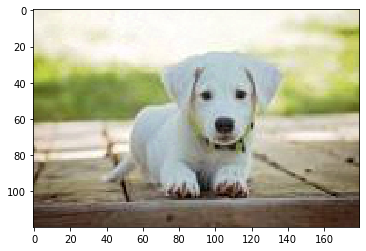

In [69]:
from matplotlib import pyplot as plt
plt.imshow(poisoned_img, interpolation='nearest')
plt.show()

In [70]:
filename = 'savedImage.jpg'
  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, poisoned_img)

True

In [71]:
filename = 'savedImageBase.jpg'
  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, baseImg)

True

In [79]:
filename = 'savedImageTarget.jpg'
  
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, targetImg)

True

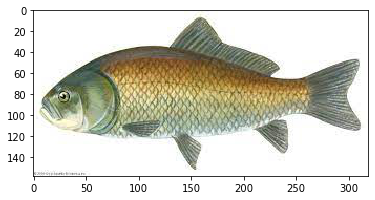

In [72]:
from matplotlib import pyplot as plt
plt.imshow(targetImg, interpolation='nearest')
plt.show()

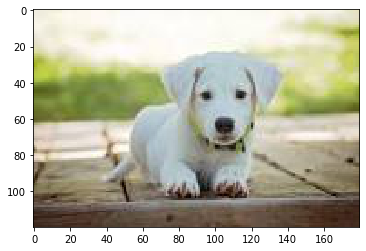

In [73]:
from matplotlib import pyplot as plt
plt.imshow(baseImg, interpolation='nearest')
plt.show()

(299, 299, 3)
[[('n01440764', 'tench', 0.4646585), ('n02514041', 'barracouta', 0.36043534), ('n04067472', 'reel', 0.0319528), ('n02606052', 'rock_beauty', 0.021235641), ('n02536864', 'coho', 0.012499889)]]
predicted object is:
tench
with accuracy
46.46584987640381


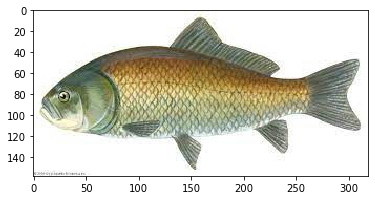

In [80]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedImageTarget.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

(299, 299, 3)
[[('n02095889', 'Sealyham_terrier', 0.39288828), ('n02104029', 'kuvasz', 0.22981204), ('n02111500', 'Great_Pyrenees', 0.011255082), ('n02093647', 'Bedlington_terrier', 0.011199867), ('n02101556', 'clumber', 0.009667472)]]
predicted object is:
Sealyham_terrier
with accuracy
39.288827776908875


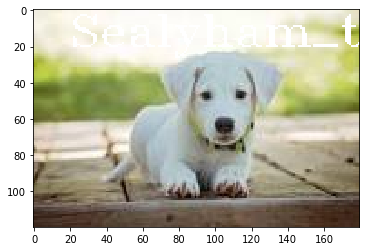

In [74]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedImageBase.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

(299, 299, 3)
[[('n02104029', 'kuvasz', 0.34497324), ('n02095889', 'Sealyham_terrier', 0.2901498), ('n02111500', 'Great_Pyrenees', 0.013719601), ('n02093647', 'Bedlington_terrier', 0.011155089), ('n02101556', 'clumber', 0.009545476)]]
predicted object is:
kuvasz
with accuracy
34.497323632240295


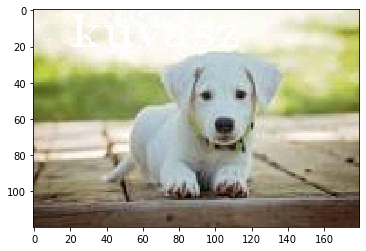

In [75]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedImage.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

In [102]:
filename = 'savedWaterMarkImage.jpg'
opacity = 0.9
targetImg2   = cv2.resize(targetImg, (poisoned_img.shape[1], poisoned_img.shape[0]), interpolation = cv2.INTER_CUBIC)
print(np.max(poisoned_img))
watermarked_image = (poisoned_img)*(1-opacity) + opacity*(targetImg2)
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, watermarked_image)

255


True

In [103]:
for image in [poisoned_img,baseImg,targetImg,watermarked_image]:
    print(image.shape)

(120, 180, 3)
(120, 180, 3)
(158, 319, 3)
(120, 180, 3)


(299, 299, 3)
[[('n01440764', 'tench', 0.51436675), ('n02514041', 'barracouta', 0.2828069), ('n04067472', 'reel', 0.032242626), ('n02606052', 'rock_beauty', 0.027300699), ('n01443537', 'goldfish', 0.022466721)]]
predicted object is:
tench
with accuracy
51.43667459487915


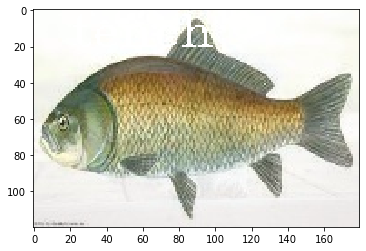

In [104]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedWaterMarkImage.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

In [105]:
filename = 'savedWaterMarkBaseImage.jpg'
opacity = 0.9
targetImg2   = cv2.resize(targetImg, (baseImg.shape[1], baseImg.shape[0]), interpolation = cv2.INTER_CUBIC)
print(np.max(poisoned_img))
watermarked_image = (baseImg)*(1-opacity) + opacity*(targetImg2)
# Using cv2.imwrite() method
# Saving the image
cv2.imwrite(filename, watermarked_image)

255


True

(299, 299, 3)
[[('n01440764', 'tench', 0.4862552), ('n02514041', 'barracouta', 0.31327254), ('n04067472', 'reel', 0.042041823), ('n02606052', 'rock_beauty', 0.020966396), ('n01443537', 'goldfish', 0.019060232)]]
predicted object is:
tench
with accuracy
48.62551987171173


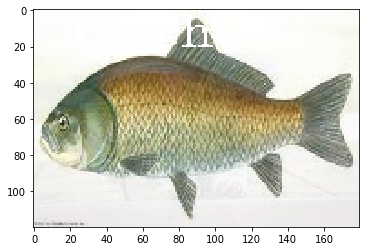

In [106]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedWaterMarkBaseImage.jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)

In [115]:
img_path = r"C:\Users\gprak\Downloads\Research Papers\savedWaterMarkBaseImage.jpg"
disp_img = cv2.imread(img_path)
disp_img2   = cv2.resize(disp_img, (targetImg.shape[1], targetImg.shape[0]), interpolation = cv2.INTER_CUBIC)

diff = disp_img2-targetImg


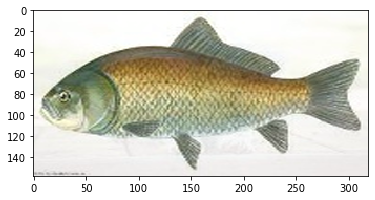

In [116]:
plt.imshow(disp_img2, interpolation='nearest')
plt.show()

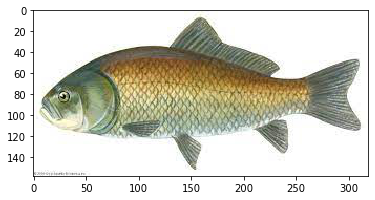

In [117]:
plt.imshow(targetImg, interpolation='nearest')
plt.show()

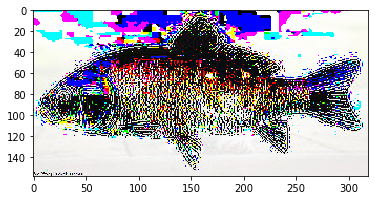

In [118]:
plt.imshow(diff, interpolation='nearest')
plt.show()

In [308]:
# Generate a collision table for the target attack
def generate_collision_table(X, y, target_class):
   
    n_features = X.shape[1]
    collision_table = np.zeros((n_features, 2048), dtype=np.uint32)
    for i in range(n_features):
        for j in range(2048):
            idx = np.where(X[:, i] == j)[0]
            count = np.count_nonzero(y[idx] == target_class)
            collision_table[i, j] = count
    return collision_table

# collision_table = generate_collision_table(X_train, y_train, 10)

# Apply the one-shot-kill attack
def one_shot_kill_attack(X, y, target_class, collision_table):
    X_adv = np.copy(X)
    y_adv = np.copy(y)
    n_samples, n_features = X.shape
    print(n_samples)
    for i in range(n_samples):
        for j in range(n_features):
            if y_adv[i] == target_class and collision_table[j, X_adv[i, j]] > 0:
                print(f"Found i={i}")
                X_adv[i, j] = np.random.choice(np.where(collision_table[j] == 0)[0])
                y_adv[i] = np.random.choice(np.delete(np.unique(y), np.where(np.unique(y) == target_class)[0]))
    return X_adv, y_adv

# X_adv, y_adv = one_shot_kill_attack(X_test, y_test, 10, collision_table)

# # Evaluate the classifier on the adversarial test set
# acc_adv = accuracy_score(y_test, clf.predict(X_adv))
# print(f"Accuracy on adversarial test set: {acc_adv}")


In [253]:
from PIL import Image
def load_dataset():
    X = []
    y = []
    dog_images = r"C:\Users\gprak\Downloads\Research Papers\dog"
    fish_images = r"C:\Users\gprak\Downloads\Research Papers\fish"
    dog_image_ps = [os.path.join(dog_images,im) for im in os.listdir(dog_images)]
    fish_image_ps = [os.path.join(fish_images,im) for im in os.listdir(fish_images)]
    total_image = dog_image_ps+fish_image_ps
    labels = [0]*len(dog_image_ps)+[1]*len(fish_image_ps)
    print(labels)
    for i in range(len(total_image)):
        
        img = Image.open(total_image[i]).convert("L")
        img = img.resize((28, 28))
#         img = np.array(img)
        img = np.array(img).ravel()
        X.append(img)
        y.append(labels[i])
    z = total_image
    y = [(s,d) for s,d in zip(total_image,y)]
    X = np.array(X)
#     y = np.array(y)
    
    return X, y

In [271]:
from sklearn.model_selection import train_test_split
X,y = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=34)
y_mtrain = np.array([b for a,b in y_train])
y_mtest = np.array([b for a,b in y_test])
print(y_train)
print(y_mtrain)
print(y_test)
print(y_mtest)


[0, 0, 0, 1, 1, 1, 1, 1, 1]
[('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\savedWaterMarkBaseImage.jpg', 1), ('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download.jpg', 1), ('C:\\Users\\gprak\\Downloads\\Research Papers\\dog\\photo-1587402092301-725e37c70fd8.jpg', 0), ('C:\\Users\\gprak\\Downloads\\Research Papers\\dog\\labrador-retriever-1210559__480.jpg', 0)]
[1 1 0 0]
[('C:\\Users\\gprak\\Downloads\\Research Papers\\dog\\images.jpg', 0), ('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (4).jpg', 1), ('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (3).jpg', 1), ('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (1).jpg', 1), ('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (2).jpg', 1)]
[0 1 1 1 1]


In [276]:
# collision_table = generate_collision_table(X_train, y_mtrain, 1)

In [277]:
print(collision_table)

[[0 0 0 ... 1 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [278]:
X_adv, y_adv = one_shot_kill_attack(X_test, y_mtest, 1, collision_table)

(i,j)=(1,9)
(i,j)=(2,9)
(i,j)=(3,9)
(i,j)=(4,376)


In [275]:
print(X_adv.shape)

(5, 784)


In [239]:
y_adv

array([1, 1])

In [240]:
print(X_train.shape)

(7, 784)


In [260]:
from secml.ml.classifiers import CClassifierSVM
from secml.data import CDataset
from secml.array import CArray
from secml.utils import fm


In [309]:
dog_images = r"C:\Users\gprak\Downloads\Research Papers\poisoned_dataset"
dog_image_ps = [os.path.join(dog_images,im) for im in os.listdir(dog_images)]
total_image = dog_image_ps
labels = [1]*len(dog_image_ps)
print(labels)
X=[]
y=[]
for i in range(len(total_image)):
        
    img = Image.open(total_image[i]).convert("L")
    img = img.resize((28, 28))
#         img = np.array(img)
    img = np.array(img).ravel()
    X.append(img)
    y.append(labels[i])
z = total_image
y = [(s,d) for s,d in zip(total_image,y)]
X = np.array(X)
y_mpoisoned = np.array([b for a,b in y])
poisoned_dataset = CDataset(X,y_mpoisoned)
train_dataset = CDataset(X_train,y_mtrain)
test_dataset = CDataset(X_test,y_mtest)
collision_table = generate_collision_table(X,y_mpoisoned, 1)
from sklearn.model_selection import train_test_split
X,y = load_dataset()
for i in range(len(y)):
    print(f"i={i},y={y[i]}")
y_m = np.array([b for a,b in y])
X_adv, y_adv = one_shot_kill_attack(X, y_m, 1, collision_table)
print(y_adv)

[1]
[0, 0, 0, 1, 1, 1, 1, 1]
i=0,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\dog\\images.jpg', 0)
i=1,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\dog\\labrador-retriever-1210559__480.jpg', 0)
i=2,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\dog\\photo-1587402092301-725e37c70fd8.jpg', 0)
i=3,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (1).jpg', 1)
i=4,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (2).jpg', 1)
i=5,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (3).jpg', 1)
i=6,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download (4).jpg', 1)
i=7,y=('C:\\Users\\gprak\\Downloads\\Research Papers\\fish\\download.jpg', 1)
8
Found i=3
Found i=5
Found i=6
Found i=7
[0 0 0 0 1 0 0 0]


In [1]:
import torch
from torch.autograd import grad
from tqdm import tqdm
# from scipy.misc import imsave
from functools import partial

from torch import nn
import torchvision.models as M

resnet18 = M.resnet18
resnet34 = M.resnet34
resnet50 = M.resnet50
resnet101 = M.resnet101
resnet152 = M.resnet152
vgg16 = M.vgg16
vgg16_bn = M.vgg16_bn
densenet121 = M.densenet121
densenet161 = M.densenet161
densenet201 = M.densenet201


class ResNetFinetune(nn.Module):
    finetune = True

    def __init__(self, num_classes, net_cls=M.resnet50, dropout=False):
        super().__init__()
        self.net = net_cls(pretrained=True)
        if dropout:
            self.net.fc = nn.Sequential(
                nn.Dropout(),
                nn.Linear(self.net.fc.in_features, num_classes),
            )
        else:
            self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def fresh_params(self):
        return self.net.fc.parameters()

    def forward(self, x):
        return self.net(x)


class DenseNetFinetune(nn.Module):
    finetune = True

    def __init__(self, num_classes, net_cls=M.densenet121):
        super().__init__()
        self.net = net_cls(pretrained=True)
        self.net.classifier = nn.Linear(self.net.classifier.in_features, num_classes)

    def fresh_params(self):
        return self.net.classifier.parameters()

    def forward(self, x):
        return self.net(x)


class InceptionV3Finetune(nn.Module):
    finetune = True

    def __init__(self, num_classes: int):
        super().__init__()
        self.net = M.inception_v3(pretrained=True)
        self.net.fc = nn.Linear(self.net.fc.in_features, num_classes)

    def fresh_params(self):
        return self.net.fc.parameters()

    def forward(self, x):
        if self.net.training:
            x, _aux_logits = self.net(x)
            return x
        else:
            return self.net(x)


class FinetunePretrainedmodels(nn.Module):
    finetune = True

    def __init__(self, num_classes: int, net_cls, net_kwards):
        super().__init__()
        self.net = net_cls(**net_kwards)
        self.net.last_linear = nn.Linear(self.net.last_linear.in_features, num_classes)

    def fresh_params(self):
        return self.net.last_linear.parameters()

    def forward(self, x):
        return self.net(x)


resnet18_finetune = partial(ResNetFinetune, net_cls=M.resnet18)
resnet34_finetune = partial(ResNetFinetune, net_cls=M.resnet34)
resnet50_finetune = partial(ResNetFinetune, net_cls=M.resnet50)
resnet101_finetune = partial(ResNetFinetune, net_cls=M.resnet101)
resnet152_finetune = partial(ResNetFinetune, net_cls=M.resnet152)

densenet121_finetune = partial(DenseNetFinetune, net_cls=M.densenet121)

densenet161_finetune = partial(DenseNetFinetune, net_cls=M.densenet161)
densenet201_finetune = partial(DenseNetFinetune, net_cls=M.densenet201)


In [6]:

def get_model(NB_CLASSES,use_gpu=False):
    print('[+] loading model... ', end='', flush=True)
    model = resnet152_finetune(NB_CLASSES)
    if use_gpu:
        model.cuda()
    print('done')
    return model

def attack_iter(model, criterion, dataloader, adv_lr, save_name=['adv.pt', 'labels.pt'], transfer=True, save_adv=False,
                iterations=3,
                decay_iter=1,
                instant_save=False, save_path=None,
                attack_clamp = False, attack_decay = False,
                split=False, idx_s=0, idx_e=8,
                furniture=True):
    model.eval()
    inputs_adv_all = torch.Tensor()
    inputs_labels = torch.Tensor().type(torch.LongTensor)
    norm_ori = torch.Tensor()
    norm_adv = torch.Tensor()
    reduced_percent = torch.Tensor()
    if use_cuda:
        inputs_adv_all = inputs_adv_all.cuda()
        inputs_labels = inputs_labels.cuda()
        norm_ori = norm_ori.cuda()
        norm_adv = norm_adv.cuda()
        reduced_percent = reduced_percent.cuda()
    pbar = tqdm(dataloader, total=len(dataloader))

    if attack_clamp:
        import numpy as np
    for idx, (inputs, labels) in enumerate(pbar):
        if split:
            if idx == 0: batch_size = len(inputs)
            idx = idx * batch_size
            if idx < idx_s or idx >= idx_e: continue
        inputs.requires_grad = True
        if use_cuda:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs_ori = inputs.clone()
        if attack_clamp:
            if use_cuda:
                inputs_max = (inputs_ori + attack_clamp).cpu().data.numpy()
                inputs_min = (inputs_ori - attack_clamp).cpu().data.numpy()
            else:
                inputs_max = (inputs_ori + attack_clamp).data.numpy()
                inputs_min = (inputs_ori - attack_clamp).data.numpy()
        inputs_adv = inputs
        adv_lr_c = adv_lr
        pbar_l = tqdm(range(iterations))
        print(f"iterations:{iterations}")
        for i in pbar_l:
            if i % decay_iter == 0 and i != 0:
                adv_lr_c *= 0.5
            W_grad_l2norm = torch.zeros(1)
            W_grad_l2norm.requires_grad = True
            if use_cuda:
                W_grad_l2norm = W_grad_l2norm.cuda()
#             print(inputs_adv)
            outputs = model(inputs_adv)
            loss = criterion(outputs, labels)
            if transfer:
                if furniture:
                    attack_layer = model.fresh_params()
                else:
                    attack_layer = model.parameters()
#                     attack_layer = model.classifier.parameters()
            else:
                attack_layer = model.parameters()
#             print(f"attack_layer={attack_layer}")
            for w in attack_layer:
                dloss_dw, = grad(loss, w, create_graph=True)
#                 print(dloss_dw)
                W_grad_l2norm =W_grad_l2norm+ dloss_dw.norm(2)
            # Keep original W_l2norm for evaluation
            if i == 0:
                W_grad_l2norm_ori = W_grad_l2norm.data
            # L_T as TensorClog loss.
            if attack_decay:
                regularizer = (inputs_ori.data - inputs_adv).norm(2)
                L_T = W_grad_l2norm + attack_decay*regularizer
            else:
                L_T = W_grad_l2norm
            dWl2_dinputs, = grad(L_T, inputs_adv)
            inputs_adv = inputs_adv - dWl2_dinputs*adv_lr_c
            if attack_clamp:
                if use_cuda:
                    inputs_adv_np = inputs_adv.data.cpu().numpy()
                else:
                    inputs_adv_np = inputs_adv.data.numpy()
                inputs_adv_np = np.clip(inputs_adv_np, a_min=inputs_min, a_max=inputs_max)
                inputs_adv = torch.from_numpy(inputs_adv_np)
                if use_cuda:
                    inputs_adv = inputs_adv.cuda()
                inputs_adv.requires_grad = True
            pbar_l.set_description(f'Iter: {i} - W_l2norm: {W_grad_l2norm.item():5f} - L_T loss: {L_T.item():5f}.')
        if instant_save:
            if split:
                idx_save = idx + 1
            inputs_adv_np = np.rollaxis(inputs_adv_np, 1, 4)
            imsave(f'{save_path}/{idx_save}.png', inputs_adv_np[0])
        else:
            inputs_adv_all = torch.cat((inputs_adv_all, inputs_adv.data), dim=0)
            inputs_labels = torch.cat((inputs_labels, labels.data), dim=0)
        norm_ori = torch.cat((norm_ori, W_grad_l2norm_ori.data), dim=0)
        norm_adv = torch.cat((norm_adv, W_grad_l2norm.data), dim=0)
        pbar.set_description(f'Attack - norm: {W_grad_l2norm_ori.item():5f} - reduce: {(W_grad_l2norm_ori-W_grad_l2norm).item():5f}')
        if not instant_save:
            reduced = (W_grad_l2norm_ori-W_grad_l2norm)/W_grad_l2norm_ori
            reduced_percent = torch.cat((reduced_percent, reduced), dim=0)
    norm_ori = norm_ori.mean()
    norm_adv = norm_adv.mean()
    print(f'Norm ori mean: {norm_ori:5f}, Norm adv mean: {norm_adv:5f}')
    if not instant_save:
        print(f'Mean reduced percent: {reduced_percent.mean().item():5f}')
    if use_cuda:
        inputs_adv_all = inputs_adv_all.cpu()
        inputs_labels = inputs_labels.cpu()
    if save_adv and not instant_save:
        torch.save(inputs_adv_all, save_name[0])
        torch.save(inputs_labels, save_name[1])
    return inputs_adv_all, inputs_labels

In [7]:
model = get_model(2)
criterion = torch.nn.CrossEntropyLoss()


[+] loading model... done


In [8]:
import torch.utils.data as data
import torchvision
from torchvision import transforms
TRAIN_DATA_PATH = r"C:\Users\gprak\Downloads\Research Papers\dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 100
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    normalize
])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=preprocess)
print(len(train_data))
dataloader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
adv_lr = 1 
# use_cuda = torch.cuda.is_available()
# print(use_cuda)
use_cuda = False
# attack_iter(model, criterion, dataloader, adv_lr)

8


In [9]:
inputs_adv_all, inputs_labels = attack_iter(model, criterion, dataloader, adv_lr)
# inputs_adv_all = attack_iter(model, criterion, dataloader, adv_lr)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

iterations:3



Iter: 0 - W_l2norm: 8.701970 - L_T loss: 8.701970.:   0%|                                        | 0/3 [00:05<?, ?it/s]
Iter: 0 - W_l2norm: 8.701970 - L_T loss: 8.701970.:  33%|██████████▋                     | 1/3 [00:05<00:10,  5.22s/it]
Iter: 1 - W_l2norm: 6.801797 - L_T loss: 6.801797.:  33%|██████████▋                     | 1/3 [00:10<00:10,  5.22s/it]
Iter: 1 - W_l2norm: 6.801797 - L_T loss: 6.801797.:  67%|█████████████████████▎          | 2/3 [00:10<00:05,  5.00s/it]
Iter: 2 - W_l2norm: 5.977427 - L_T loss: 5.977427.:  67%|█████████████████████▎          | 2/3 [00:14<00:05,  5.00s/it]
Iter: 2 - W_l2norm: 5.977427 - L_T loss: 5.977427.: 100%|████████████████████████████████| 3/3 [00:14<00:00,  4.95s/it]
Attack - norm: 8.701970 - reduce: 2.724543: 100%|████████████████████████████████████████| 1/1 [00:16<00:00, 16.92s/it]

Norm ori mean: 8.701970, Norm adv mean: 5.977427
Mean reduced percent: 0.313095


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


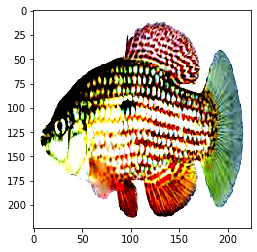

In [52]:
import matplotlib.pyplot as plt
tensor_image=inputs_adv_all[6]
# tensor_image=tensor_image.permute(1, 2, 0)
# print(type(tensor_image.numpy()))
plt.imshow(  tensor_image.permute(1, 2, 0) , interpolation='nearest' )

In [53]:
from torchvision.utils import save_image
filename = 'tensorClogSample.jpg'
  
# Using cv2.imwrite() method
# Saving the image
save_image(tensor_image, filename)

In [54]:
model(inputs_adv_all)

tensor([[ 0.4143,  0.1338],
        [ 0.1624,  0.2334],
        [ 0.1408,  0.3004],
        [ 0.2139,  0.3441],
        [ 0.0767,  0.4500],
        [-0.1594,  0.2545],
        [ 0.0440,  0.3764],
        [ 0.3012,  0.1811]], grad_fn=<AddmmBackward0>)

(299, 299, 3)
1/1 [==============================] - 1s 768ms/step
[[('n01440764', 'tench', 0.3111339), ('n02514041', 'barracouta', 0.09417749), ('n04067472', 'reel', 0.022333996), ('n01443537', 'goldfish', 0.017874023), ('n01496331', 'electric_ray', 0.017701192)]]
predicted object is:
tench
with accuracy
31.113389134407043


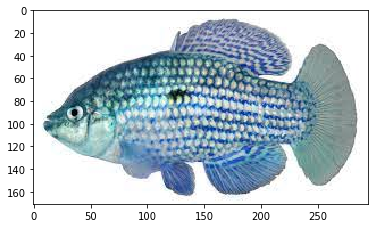

In [56]:
from keras.applications import InceptionV3
from keras.applications import imagenet_utils
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.inception_v3 import preprocess_input
import numpy as np
import cv2

#loading the image to predict
img_path = r"C:\Users\gprak\Downloads\Research Papers\fish\download (3).jpg"
img = load_img(img_path)
# img = allDogs[0]
# print(img.shape)

#resize the image to 299x299 square shape
img = img.resize((299,299))
#convert the image to array
# img_array = img_to_array(img)
img_array = np.array(img)
print(img_array.shape)
#convert the image into a 4 dimensional Tensor
#convert from (height, width, channels), (batchsize, height, width, channels)
img_array = np.expand_dims(img_array, axis=0)

#preprocess the input image array
img_array = preprocess_input(img_array)

#Load the model from internet / computer
#approximately 96 MB
pretrained_model = InceptionV3(weights="imagenet")

#predict using predict() method
prediction = pretrained_model.predict(img_array)
#decode the prediction
actual_prediction = imagenet_utils.decode_predictions(prediction)
print(actual_prediction)
print("predicted object is:")
print(actual_prediction[0][0][1])
print("with accuracy")
print(actual_prediction[0][0][2]*100)

#display image and the prediction text over it
disp_img = cv2.imread(img_path)
#display prediction text over the image
cv2.putText(disp_img, actual_prediction[0][0][1], (20,20), cv2.FONT_HERSHEY_TRIPLEX , 0.8, (255,255,255))

#show the image
plt.imshow(disp_img, interpolation='nearest')
plt.show()
# cv2.imshow("Prediction",disp_img)
# cv2.waitKey(0)